In [1]:
#For å kjøre GPU framfor CPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


2023-04-17 11:26:15.062051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


There are a few things you can try to make your code run faster:

Use a GPU: If you have access to a GPU, you can use it to accelerate the computations. You can check if your code is using a GPU by running torch.cuda.is_available(). If it returns True, then you can use the GPU by calling learn.to_fp16() before training.
Reduce the batch size: The batch size determines how many examples are processed at once. If the batch size is too large, it can cause out-of-memory errors or slow down the training process. You can try reducing the batch size by setting it to a smaller value, e.g., dls.batch_size = 16.
Use mixed-precision training: Mixed-precision training is a technique that uses half-precision floating-point format to accelerate the computations. You can enable mixed-precision training by calling learn.to_fp16() before training.
Use a smaller model: If the model is too large, it can slow down the training process. You can try using a smaller model by changing resnet18 to a smaller model, such as resnet10.
Use transfer learning: Transfer learning is a technique that uses a pre-trained model as a starting point for training a new model. You can try using transfer learning by calling learn.freeze() before training to freeze the pre-trained layers and then calling learn.fit_one_cycle(1, 1e-3) to fine-tune the model.
Increase the number of epochs: If the model is not converging after one epoch, you can try increasing the number of epochs by passing a larger value to learn.fine_tune(), e.g., learn.fine_tune(5).
By trying these different techniques, you can optimize the training process and make it run faster.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import pickle
import nibabel as nib
from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split
from fastMONAI.vision_all import *
from PIL import Image 
import PIL 
import numpy.ma as ma
import matplotlib.pyplot as plt
import cv2


In [1]:
path = Path('../data/processed/IXI_2d_slices/')
fnames = get_image_files(path / "Axial")
masks = get_image_files(path / "AxialMask")
img_fn = fnames[5]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

NameError: name 'Path' is not defined

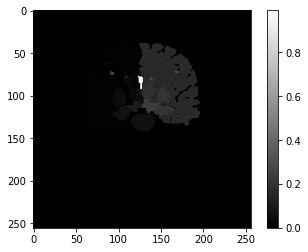

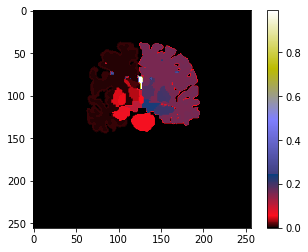

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the PNG mask image
mask = mpimg.imread(path/'Raskere/IXI012-HH-1211-2d_axial-mask.png')

# Display the PNG mask image
plt.imshow(mask, cmap='gray')
plt.colorbar()
plt.show()

# Apply a colormap to the PNG mask image
plt.imshow(mask, cmap='gist_stern')
plt.colorbar()
plt.show()

#cmap='plasma'

In [5]:
codes = np.loadtxt(path/'code-kopi_kuttet.txt', dtype=str)
codes

array([['0', 'Unknown', '0', '0', '0', '0\\'],
       ['1', 'Left-Cerebral-Exterior', '70', '130', '180', '0\\'],
       ['2', 'Left-Cerebral-White-Matter', '245', '245', '245', '0\\'],
       ...,
       ['702', 'GrayMatter-FSL-FAST', '205', '62', '78', '0\\'],
       ['703', 'WhiteMatter-FSL-FAST', '0', '225', '0', '0\\'],
       ['999', 'SUSPICIOUS', '255', '100', '100', '0\\']], dtype='<U39')

In [6]:
get_msk = lambda o: path/'AxialMask'/f'{o.stem}-mask{o.suffix}'

In [7]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [8]:
(path/"Axial").ls()[0]

Path('../data/processed/IXI_2d_slices/OK/IXI131-HH-1527-2d_axial.png')

In [10]:
dls = SegmentationDataLoaders.from_label_func(
     path, bs=8, fnames = fnames, label_func = get_msk, codes = codes, cmap = 'gist_stern'
)

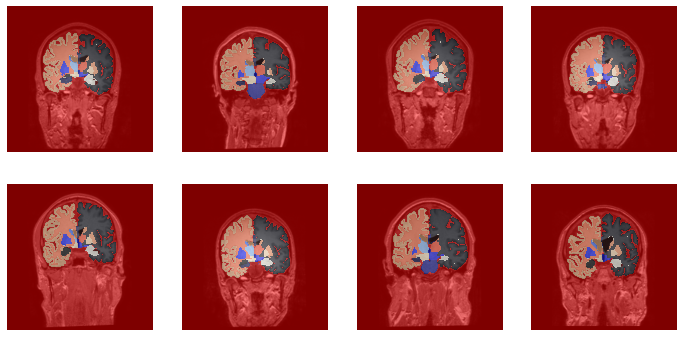

In [11]:
dls.show_batch(max_n=8, cmap = 'flag') #cmap = 'gist_stern'

In [12]:
learn = unet_learner(dls, resnet34)

learn.fine_tune(2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,3.184352,0.773397,09:10


epoch,train_loss,valid_loss,time
0,0.513332,0.550020,08:11
1,0.439422,0.281175,09:50
2,0.339923,0.218646,10:24


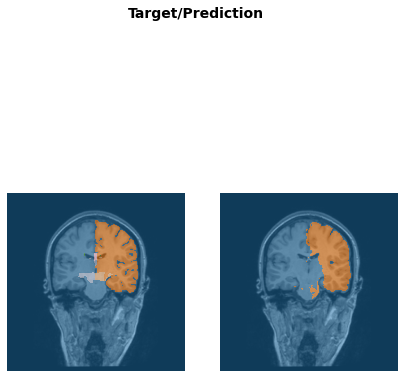

In [13]:
learn.show_results(max_n=1, figsize=(7,8))

In [14]:
learn.summary()

DynamicUnet (Input shape: 8 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 128 x 128  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 64 x 64    
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [15]:
learn.lr_find()

In [ ]:
lr = 1e-1 #(=1^-1 == 0.1)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')

In [ ]:
learn.fit_flat_cos(10, slice(lr))

In [ ]:
learn.show_results(max_n=4, figsize=(12,6))